In [15]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from ekf_vindy.plotting import plotter
from ekf_vindy.utils import add_noise_with_snr
from ekf_vindy.filters.config import DynamicsConfig
from ekf_vindy.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

# EKF-SINDy with Duffing oscillator

We examine a simulation with a Duffing oscillator, and we want to inform the filter about energy conservation. Some possible examples

- Start from a wrong model (obtained by SINDy), where there's a damping term. Such a damping term must fade during online inference. However, we should be able to see the term disappear faster in the physics-informed EKF case.
- The other way around, learn a system where energy is conserved, and energy gradually is lost via a damping term that becomes active after a certain point during the online phase. Again, we should see the EKF be faster in adapting to the environment given the constraint. 

## Duffing oscillator

The undamped Duffing oscillator is the following

$$
\ddot{x}+\alpha x + \beta x^3 + \gamma x^5= 0
$$

Energy is conserved (a physical constraint in an isolated system). We will also considered the damped oscillator.

$$
\ddot{x}+\delta \dot{x}+\alpha x+ \beta x^3  + \gamma x^5= 0, \,\,\delta > 0
$$

We consider the first-order version of the damped oscillator

$$
\begin{aligned}
\dot{x}_0 &= x_1,\\
\dot{x}_1 &= - \alpha x_0-  \beta x_0^3 -\gamma x_0^5 - \delta x_1
\end{aligned}
$$

In [21]:
def duffing_oscillator(x, t, params, t_conservation):
    """
    Duffing oscillator ODE
    """
    if t >= t_conservation:
        delta = 0.0
    else:
        delta = params['delta']
    
    dxdt = x[1]
    dvdt = - params['alpha'] * x[0] - params['beta'] * x[0] ** 3 - params['gamma'] * x[0] ** 5 - delta * x[1]
    
    return [dxdt, dvdt]

The total energy of this system is given by the Hamiltonian (potential and kinetic energy). 

$$
H(x(t), \dot{x}(t)) = \frac{1}{2}\dot{x}^2(t) +\frac{1}{2}\alpha x^2(t) +\frac{1}{4}\beta x^4(t) + \frac{1}{6}\gamma x^6(t). 
$$

So want we want to enforce is that the energy at the initial state (assuming there's no loss), is equal to the energy in successive states. So

$$
g(x(t), \dot{x}(t)) = H(x(t), \dot{x}(t)) - H(x(0), \dot{x}(0)) = 0
$$

Since we will put this into the filter, as a pseudo-observation, we must linearize the constraint $g(x(t), \dot{x}(t))$, so we need its Jacobian. In this case, we can easily derive in closed-form.

In [17]:
def energy(x):
    """
    Hamiltonian (total energy) of the Duffing oscillator
    """
    alpha = 1   # Linear stiffness
    beta = 1     # Nonlinear stiffness
    gamma = 1    # Quintic term coefficient
    
    kinetic = 0.5 * x[1]**2
    potential = 0.5 * alpha * x[0]**2 + 0.25 * beta * x[0]**4 + (1/6) * gamma * x[0]**6
    
    return kinetic + potential

def jacobian_constraint(x):
    """
    Jacobian of the energy constraint
    """
    alpha = 1   # Linear stiffness
    beta = 1     # Nonlinear stiffness
    gamma = 1    # Quintic term coefficient
    
    dH_dx = np.array([alpha * x[0] + beta * x[0]**3 + gamma * x[0]**5, x[1]])
    
    return dH_dx

Generate trajectories in the undamped case and train SINDy...

(x0)' = 0.975 x1 + 0.119 x0^3 + -0.068 x0^5
(x1)' = -0.765 x0 + -0.529 x1 + 0.724 x0^2 + 0.106 x0 x1 + -1.780 x0^3 + 0.320 x0^2 x1 + -0.581 x0^4 + -1.621 x0^5 + -0.139 x0^4 x1


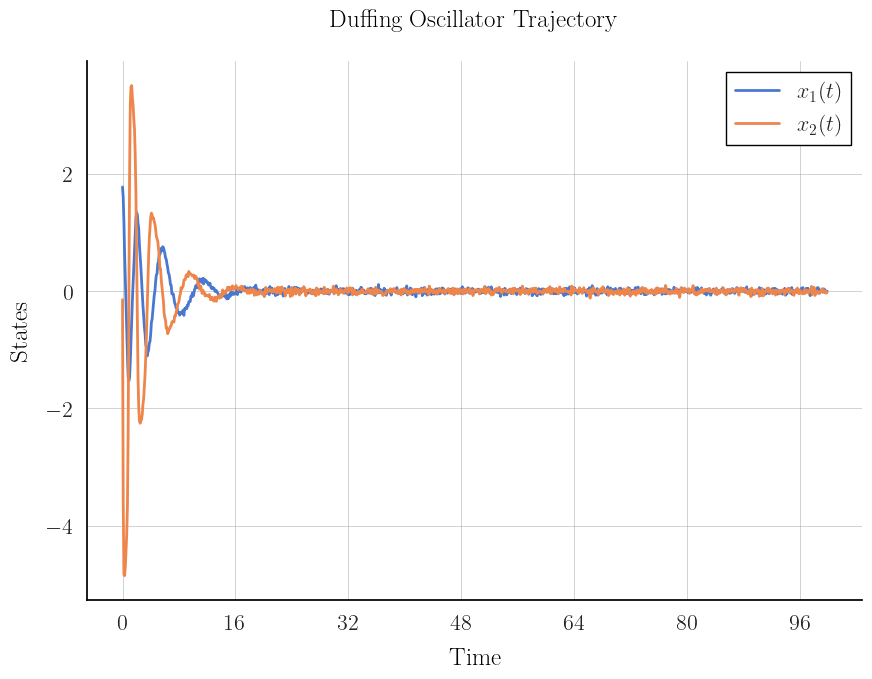

In [22]:
params = {
    'alpha': 1,   # Linear stiffness
    'beta': 1,     # Nonlinear stiffness
    'gamma': 2,    # Higher-order stiffness
    'delta': 0.5,  # Damping coefficient
}

# Generate training data (around [1.5, 0] initial condition)
t_conservation = 100.0 # energy is depleted by then

n_train = 20
std = 0.5
mean_ic = np.array([1.5, 0.0])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 100, 0.1)
x_train = []


for i in range(n_train):
    sol = odeint(duffing_oscillator, x_0[i, :], time_instances, args=(params, t_conservation))
    x_train.append(sol)

x_train = np.array(x_train)
# x_train = [traj for traj in x_train]
x_train = [noisy_traj for noisy_traj in add_noise_with_snr(x_train, snr=20)]

model = ps.SINDy(feature_names=['x0', 'x1'],
                 feature_library=ps.PolynomialLibrary(degree=5),
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(x_train, t=0.1, multiple_trajectories=True)
model.print()

# plot one trajectory from x_train
fig, ax = plotter.plot_trajectory(x_train[0], time_instances, title='Duffing Oscillator Trajectory', xlabel='Time', ylabel='States')
plt.show()

What if system suddenly becomes conservative? So the damping term $\delta$ goes to zero abruptly. We define the constraint object and set a very small noise (can you do the update at the same time?)

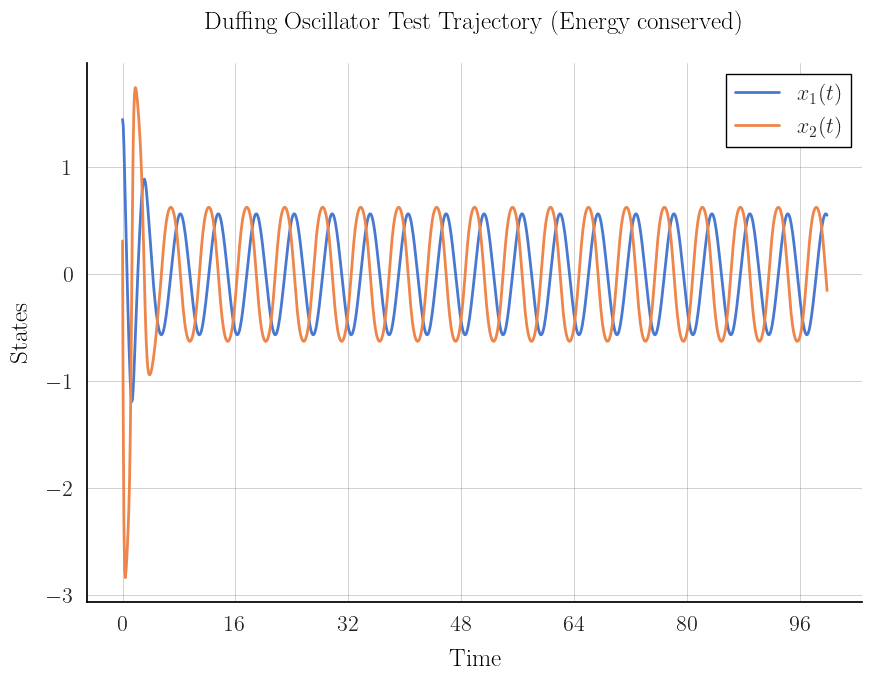

In [30]:
from ekf_vindy.filters.constraints import Constraint

t_conservation = 0.0
time_instances = np.arange(0, 100, 0.1)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))

fig, ax = plotter.plot_trajectory(x_test, time_instances, title='Duffing Oscillator Test Trajectory (Energy conserved)', xlabel='Time', ylabel='States')
plt.show()

def energy_conservation(x):
     return np.array([energy(x) - energy(x_0_test)])

# constraint_noise = np.diag([1e-5])
# constraint = Constraint(co)